In [10]:
from copy import copy
import numpy as np
from numpy.random import default_rng
from sklearn.linear_model import RANSACRegressor
from sklearn.datasets import make_regression
rng = default_rng()
from scipy.stats import norm
import torch.nn as nn
import torch
import torch.nn.functional as F


In [11]:
#### Creating Modelwith Pytorch

class ANN_Model(nn.Module):
    def __init__(self, input_features=1, out_features=1):
        super().__init__()
        self.out=nn.Linear(input_features,out_features)
    def forward(self,x):
        x = torch.tensor(x).to(dtype=torch.float)
        x = self.out(x)
        return x

In [12]:
#model = ANN_Model()

def fit(model, X_train, y_train, n):
    epochs = 10
    optimizer=torch.optim.SGD(model.parameters(), lr=0.05)
    Loss_function = nn.L1Loss()
    optimizer.zero_grad()
    for i in range(epochs):
        y_pred = model.forward(X_train)
        y_train = np.asarray(y_train)
        y_train = y_train.reshape(n,1)
        y_train = torch.from_numpy(y_train)
        loss = Loss_function(y_pred,y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [13]:
class RANSAC:
    def __init__(self, n=10, k=100, t=3, d=10, model=None, loss=None, metric=None):
        self.n = n              # `n`: Minimum number of data points to estimate parameters
        self.k = k              # `k`: Maximum iterations allowed
        self.t = t              # `t`: Threshold value to determine if points are fit well
        self.d = d              # `d`: Number of close data points required to assert model fits well
        self.model = model      # `model`: class implementing `fit` and `predict`
        self.loss = loss        # `loss`: function of `y_true` and `y_pred` that returns a vector
        self.metric = metric    # `metric`: function of `y_true` and `y_pred` and returns a float
        self.best_fit = None
        self.best_error = np.inf
        self.outliers = []
        self.inliers = []

    def fit(self, X, y):
        for _ in range(self.k):
            # get n random data points from dataset
            ids = rng.permutation(X.shape[0])
            maybe_inliers = ids[: self.n]
            maybe_model = copy(self.model)
            
            # train a model with n data points that are considered as inliers
            fit(maybe_model, X[maybe_inliers], y[maybe_inliers], self.n)
            
            # pick all data points, which satisfy the threshold t
            inlier_ids = []
            for i in ids:
                if(i not in maybe_inliers):
                    y_pred = maybe_model.forward(X[i])
                    loss = self.loss(y[i],y_pred)
                    #print(i, loss)
                    if(loss < self.t):
                        inlier_ids.append(i)
            inlier_ids = np.array(inlier_ids)
            
            # Consider if the number of data points that are classified as inliers is sufficient to fit a better model
            if inlier_ids.size > self.d:
                # List of data points that are classified as inliers in this iteration
                inlier_points = np.hstack([maybe_inliers, inlier_ids])

                # List of outliers of this iteration
                outlier = []
                for i in ids:
                    if(i not in inlier_points):
                        outlier.append(i) 

                # train a model with data points in inlier_points
                better_model = copy(self.model)
                fit(better_model, X[inlier_points], y[inlier_points],len(inlier_points))

                # calcualte the error in this iteration
                yin = better_model.forward(X[inlier_points]).detach().numpy()
                yin = yin.reshape(len(inlier_points))                
                this_error = self.metric(y[inlier_points], yin)   

                # If this error is smaller than our best error we had before, we must replace it
                if this_error < self.best_error:
                    self.best_error = this_error
                    self.best_fit = better_model
                    self.outliers = outlier
                    self.inliers = inlier_points

        return self

    def predict(self, X):
        return self.best_fit.forward(X)
        

In [14]:
def square_error_loss(y_true, y_pred):
    return (y_true - y_pred) ** 2


def mean_square_error(y_true, y_pred):
    return np.sum(square_error_loss(y_true, y_pred)) / y_true.shape[0]

In [15]:
def gentest(samples,outliers_size):
    X = []
    Y = []
    for i in range(samples):
        x = 4*(np.random.rand()-0.5)
        X.append(x)
        mu = x*5
        y = mu+np.random.normal(0,1,1)[0]
        Y.append(y)
    #gen outliers
    for i in range(outliers_size):
        x = 4*(np.random.rand()-0.5)
        X.append(x)
        mu = x*15*np.random.rand()
        y = mu+np.random.normal(0,1,1)[0]
        Y.append(y)
    return np.array(X),np.array(Y)

In [16]:
def check(model, sample_size, index):
    Sigma = np.identity(sample_size)
    # construct eta
    e1 = np.zeros((sample_size,1))
    e1[index][0] = 1
    Mat = np.zeros((sample_size,sample_size))
    for i in inliers:
        Mat[i][i] = 1
    X_M = np.ones((sample_size,1))
    for i in outliers:
        X_M[i][0] = 0
    for i in range(sample_size):
        X_M[i][0] *= X[i][0]
    Xobs = X[index]
    Xovs = Xobs.reshape(1,1)
    e2 = (X_M.T)/(np.dot(X_M.T,X_M))
    e2.reshape((sample_size,1))
    eta = (e1 - np.dot(Xobs,np.dot(e2,Mat))).T
    # hypothesis testing
    etaT_Sigma_eta = np.dot(np.dot(eta.T, Sigma), eta)
    etaT_Y = np.dot((eta.T)[0],y)
    cdf = norm.cdf(etaT_Y, loc = 0, scale = np.sqrt(etaT_Sigma_eta[0][0]))
    p_value = min(cdf, 1-cdf) * 2
    return p_value

Number of outliers:  25
[106, 81, 74, 105, 109, 100, 110, 107, 72, 103, 83, 108, 7, 114, 12, 4, 94, 76, 111, 77, 104, 31, 15, 17, 113]


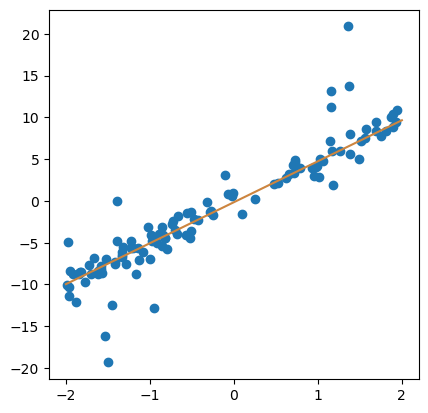

Percentage of the rejection:  1.0


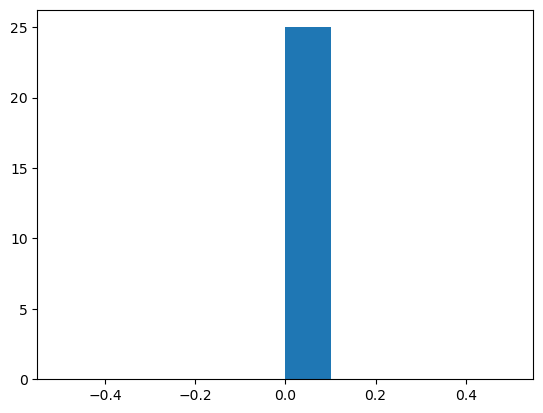

In [26]:
if __name__ == "__main__":
    inliers_size = 100
    outliers_size = 15
    #model = ANN_Model()
    regressor = RANSAC(model = ANN_Model(),loss=square_error_loss, metric=mean_square_error)
    X,y = gentest(inliers_size,outliers_size)
    X = X.reshape((inliers_size+outliers_size,1))
    regressor.fit(X, y)
    outliers = regressor.outliers
    inliers = regressor.inliers
    print("Number of outliers: ",len(outliers))
    print(outliers)

    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 1)
    ax.set_box_aspect(1)
    plt.scatter(X, y)
    line = np.linspace(-2, 2, num=100).reshape(-1, 1)
    plt.plot(line, regressor.predict(line).detach().numpy(), c="peru")
    plt.show()
    p_values = []
    # check the validity of the p-value
    for i in outliers:
        p_values.append(check(regressor,inliers_size+outliers_size, i))
    alpha = 0.5
    reject_count = 0
    for p_value in p_values:
        if p_value < alpha:
            reject_count += 1
    print("Percentage of the rejection: ",reject_count / len(p_values))
    plt.hist(p_values)
    plt.show()
